## Loading libraries

In [65]:
import torch
import torchvision
from torchvision import datasets, models, transforms
import os
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import utils
import torch.nn as nn
import torch.optim as optim

## Device configuration

In [66]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Functions

### Underline text

In [67]:
def underlined_text(text, char = '='):
    length = len(text)
    print(text)
    print(char*length)

### imshow()

In [68]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

### predicted_labels()

In [69]:
def predicted_labels(model, imgs):
    out = model(imgs)
    _, pred_lbls = torch.max(out, dim=1)
    return pred_lbls

## Loading AlexNet pretrained model

Note that you can construct the model with random weights calling its constructor with <b>pretrained = False</b> (default).

In [70]:
alex_net = models.alexnet(pretrained=True)
print(alex_net)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

## Preparing the model for transfer learning

### Turning off  (freezing) parameters for training

We need to keep pre-trained values of the model and only to train the last layers (classifier). Therefore, we first freeze all parameters of the model.

In [71]:
for param in alex_net.parameters():
    param.requires_grad = False

### Final layer of the classifier

In [72]:
print(alex_net.classifier[6])

Linear(in_features=4096, out_features=1000, bias=True)


### Replacing the final layer with custom layers

Here, we are going to replace the final layer (of classifier) with custom linear layers.

In [73]:
alex_net.classifier[6] = nn.Sequential(
    nn.Linear(in_features=4096, out_features=256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(in_features=256, out_features=2), # Two classes - bees and ants
    nn.LogSoftmax(dim=1)
)
print(alex_net.classifier[6])

Sequential(
  (0): Linear(in_features=4096, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.4, inplace=False)
  (3): Linear(in_features=256, out_features=2, bias=True)
  (4): LogSoftmax()
)


### Checking custom layers are trainable 

In [74]:
for layer in alex_net.classifier[6]:
    for param in layer.parameters():
        print("{} layer's requires_grad is {}".format(layer, param.requires_grad))

Linear(in_features=4096, out_features=256, bias=True) layer's requires_grad is True
Linear(in_features=4096, out_features=256, bias=True) layer's requires_grad is True
Linear(in_features=256, out_features=2, bias=True) layer's requires_grad is True
Linear(in_features=256, out_features=2, bias=True) layer's requires_grad is True


### Total number of trainable parameters

In [75]:
ttl_params = 0
ttl_trainable_params = 0
for param in alex_net.parameters():
    if param.requires_grad == True:
        ttl_trainable_params += param.numel() # Returns the total number of elements in the tensor
    ttl_params += param.numel()
print("Number of trainable parameters = {}\nTotal number of parameters = {}\n% of trainable parameters = {:5.2f}".
      format(ttl_trainable_params, ttl_params, (ttl_trainable_params*100.0)/ttl_params))

Number of trainable parameters = 1049346
Total number of parameters = 58053186
% of trainable parameters =  1.81


### Modified AlexNet

In [76]:
print(alex_net)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Added layers are trainable since their requires_grad is True.

## Define transforms

All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

### Train transforms

In [77]:
train_transforms = transforms.Compose([
    # Apply the following transformations one by one
    transforms.RandomResizedCrop(224),  # Extract a random patch of size (224, 224)
    transforms.RandomHorizontalFlip(),  # Horizontally flip randomely with a given probability(default = 0.5)
    transforms.ToTensor(),              # Convert a PIL image to tensor (H,W,C) in the range [0,255] to 
                                        # a torch tensor (C,H,W) in the range [0.0, 1.0] 
                                        # where H - Height, W - Width and C - Channel
    transforms.Normalize(
        [0.485, 0.456, 0.406],          # Means use to normalize C, H and W respectively
        [0.229, 0.224, 0.225])          # Std. Divs. use to normalize C, H and W respectively
                                        # As we use a pre-trained model, we need to use the means and
                                        # stds specified by PyTorch
])

underlined_text("Train transforms")
print(train_transforms)

Train transforms
Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


### Validation transforms

In [78]:
val_transforms = transforms.Compose([
    transforms.Resize(256),             # Resize the image s.t. smaller side set to 256, 
                                        # the other side is scaled to maintain the aspect ration.
    transforms.CenterCrop(224),         # Crops the center part of the image of shape (224, 224) 
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],          # Means use to normalize C, H and W respectively
        [0.229, 0.224, 0.225])          # Std. Divs. use to normalize C, H and W respectively
])

underlined_text("Validation transforms")
print(val_transforms)

Validation transforms
Compose(
    Resize(size=256, interpolation=PIL.Image.BILINEAR)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


## Loading the dataset, applying the transformations and put them into DataLoader

### Loading datasets and applying transformations 

The 'datasets.ImageFolder' expects images to be stored in the following way:

> data_dir/label/picture_name.jpg

where 'label' is the name of the class. 

For example, all images of 'ants' and 'bees' should be in a separate folders as follows:

> hymenoptera_data/train/ants<br>
hymenoptera_data/train/bees<br>
hymenoptera_data/val/ants<br>
hymenoptera_data/val/bees

In [79]:
data_dir = 'hymenoptera_data'

train_set = datasets.ImageFolder(           # A generic data loader where image classes are arranged in folders
    root=os.path.join(data_dir, 'train'),   # Image directory path
    transform=train_transforms              # Apply series of transformation defined earlier to images in the
                                            # folder 'data_dir/train'
)

underlined_text("train_set")
print(train_set)

val_set = datasets.ImageFolder(
    root=os.path.join(data_dir, 'val'),     # Image directory path
    transform=val_transforms                # Apply series of transformation defined earlier to images in the
                                            # folder 'data_dir/val'
)

underlined_text("val_set")
print(val_set)

train_set
Dataset ImageFolder
    Number of datapoints: 244
    Root location: hymenoptera_data/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
val_set
Dataset ImageFolder
    Number of datapoints: 153
    Root location: hymenoptera_data/val
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


### Putting datasets into DataLoaders

DataLoader is able to randomly break down the dataset into small batches, train the model on each batch one by one. Hence, we don't need to work with the entire dataset and training becomes more efficient.

In [80]:
trainDL = DataLoader(dataset=train_set, batch_size=8, shuffle=True)
valDL = DataLoader(dataset=val_set,batch_size=8, shuffle=True)

print("Data Loaders:\nTrain = {}\nValidation = {}".format(trainDL, valDL))

Data Loaders:
Train = <torch.utils.data.dataloader.DataLoader object at 0x7f095a79e850>
Validation = <torch.utils.data.dataloader.DataLoader object at 0x7f095a79e310>


### Getting the first batch of images and their labels

Shape of images = torch.Size([8, 3, 224, 224])
Shape of lebels = torch.Size([8])


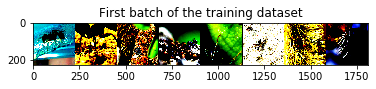

Predicted labels (before training)
Original labels  =  tensor([0, 0, 0, 0, 0, 0, 0, 1])
Predicted labels =  tensor([0, 1, 1, 1, 0, 0, 1, 0])


In [81]:
for data in trainDL:
    images, labels = data
    print("Shape of images = {}\nShape of lebels = {}".format(images.shape, labels.shape))
    imshow(utils.make_grid(images), "First batch of the training dataset")
    
    underlined_text("Predicted labels (before training)")
    print("Original labels  = ", labels)
    pred_lbls = predicted_labels(alex_net, images)
    print("Predicted labels = ", pred_lbls)
    break

## Training

### Moving model

In [82]:
alex_net = alex_net.to(device)

### Model Evaluation

In [83]:
def model_evaluation(dataloader, model, device):
    total = 0
    correct = 0
    
    for data in dataloader:
        imgs, lbls = data
        imgs = imgs.to(device)
        lbls = lbls.to(device)
        out = model(imgs)
        #Obtain the max values and its index (predicted class) of each output
        max_vals, pred_class = torch.max(out, dim=1)
        total += torch.numel(lbls)
        correct += (pred_class==lbls).sum().item()
        acc = (100.0*correct)/total
    
    return acc

### Defining the loss function and optimizer

In [84]:
loss_fn = nn.NLLLoss() # Negative log likelihood loss. Useful for classification probelms
optimizer = optim.Adam(alex_net.parameters())

### Training loop

In [85]:
EPOCHS = 20

print("Started Training on", device, " ...")
for epoch in range(EPOCHS):
    for data in trainDL:
        imgs, lbls = data
        imgs = imgs.to(device)
        lbls = lbls.to(device)
        optimizer.zero_grad()
        out = alex_net(imgs)
        loss = loss_fn(out, lbls)
        loss.backward()
        optimizer.step()

    train_acc = model_evaluation(trainDL, alex_net, device)
    val_acc  = model_evaluation(valDL, alex_net, device)
    
    print("Epoch: {:4d}/{:4d} ==> Loss = {:8.5f}, Val Acc = {:8.5f}, Train Acc = {:8.5f}".
          format(epoch+1, EPOCHS, loss.item(), val_acc, train_acc))
       
print('Finished Training.')
net = alex_net.to('cpu') #Trained network bring back to the CPU as GPU has limited memory

Started Training on cuda  ...
Epoch:    1/  20 ==> Loss =  0.00423, Val Acc = 87.58170, Train Acc = 88.11475
Epoch:    2/  20 ==> Loss =  0.29705, Val Acc = 84.31373, Train Acc = 93.85246
Epoch:    3/  20 ==> Loss =  0.00088, Val Acc = 90.19608, Train Acc = 92.62295
Epoch:    4/  20 ==> Loss =  0.43681, Val Acc = 89.54248, Train Acc = 91.80328
Epoch:    5/  20 ==> Loss =  0.00016, Val Acc = 90.19608, Train Acc = 93.03279
Epoch:    6/  20 ==> Loss =  0.00422, Val Acc = 88.88889, Train Acc = 96.72131
Epoch:    7/  20 ==> Loss =  0.01795, Val Acc = 88.23529, Train Acc = 96.31148
Epoch:    8/  20 ==> Loss =  0.01093, Val Acc = 86.92810, Train Acc = 95.49180
Epoch:    9/  20 ==> Loss =  0.00970, Val Acc = 88.23529, Train Acc = 95.90164
Epoch:   10/  20 ==> Loss =  0.00022, Val Acc = 84.96732, Train Acc = 96.31148
Epoch:   11/  20 ==> Loss =  0.00104, Val Acc = 88.88889, Train Acc = 94.67213
Epoch:   12/  20 ==> Loss =  0.17959, Val Acc = 81.04575, Train Acc = 91.80328
Epoch:   13/  20 ==> L

## Predictions

Shape of images = torch.Size([8, 3, 224, 224])
Shape of lebels = torch.Size([8])


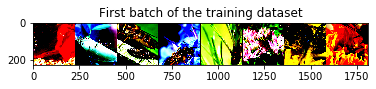

Predicted labels (after training)
Original labels  =  tensor([0, 0, 1, 1, 0, 1, 1, 1])
Predicted labels =  tensor([0, 0, 1, 1, 0, 1, 1, 1])


In [86]:
for data in trainDL:
    images, labels = data
    print("Shape of images = {}\nShape of lebels = {}".format(images.shape, labels.shape))
    imshow(utils.make_grid(images), "First batch of the training dataset")
    
    underlined_text("Predicted labels (after training)")
    print("Original labels  = ", labels)
    pred_lbls = predicted_labels(alex_net, images)
    print("Predicted labels = ", pred_lbls)
    break